### In this notebook we will see, how bottleneck Influences on simple ResNet.
ResNet: 
* [paper](https://arxiv.org/abs/1512.03385)
* [inplementation](https://github.com/analysiscenter/az_training/blob/darima_mylzenova/standard_models/resnet.py)

### For that we train two networks presented below.
#### First network - simple ResNet include five blocks:
feature of this network is we use only convolution with kernel 3x3, and skipconnetions without training parameters.
<img src="./pictures/resnet.png">
### total weights: 617472

### Second model - Resnet with bottlenecks blocks:
In this case we use the convolutions 1×1 layers are responsible for reducing and then increasing (restoring)
dimensions(by change number of filters). Now skipconnetions has training parameters, that allow it to train.
<img src="./pictures/bottleneck.png">
### total weights: 211712

In [1]:
import sys
import os

import blosc
import numpy as np
import seaborn as sns
import tensorflow as tf
from pandas import ewma
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
from tqdm import tqdm_notebook as tqn

sys.path.append('..')
from resnet_model import ResNetModel
from dataset import B,V,F
from dataset.dataset.opensets import MNIST

As always create MNIST batch class

In [2]:
dset = MNIST()

ExtractingExtractingExtracting  Extracting/tmp/t10k-labels-idx1-ubyte.gz /tmp/train-images-idx3-ubyte.gz 
/tmp/t10k-images-idx3-ubyte.gz
/tmp/train-labels-idx1-ubyte.gz



### Now let's train this model and compare results. 

### Create dataset, train both models on MNIST dataset and mark the execution time by tqdm library.

In [3]:
ResNet_config = {
    'input': {
        'shape': [28, 28, 1],
        'n_classes': 10
             },
    'loss': 'softmax_cross_entropy',
    'optimizer': 'Adam'
} 
bottlenet_config = {**ResNet_config,
                          'bottleneck': True}

In [4]:
placehold_dict = {'input': B('images'),
                  'labels': B('labels')}

In [5]:
res_pipeline = (dset.train
           .p
           .init_variable('loss', init_on_each_run=list)
           .init_model('dynamic',
                      ResNetModel,
                      'resnet',
                      config=ResNet_config)
           .train_model('resnet',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('loss'), mode='a'))

In [6]:
for i in tqn(range(500)):
    res_pipeline.next_batch(200, n_epochs=None, shuffle=True)
    
    if i%10==0:
        clear_output(True)
        plt.plot(ewma(np.array(pipeline.get_variable('loss')[-100:]),span=10,adjust=False))
        plt.show()

(?, 7, 7, 64) (?, 7, 7, 64)
(?, 7, 7, 64) (?, 7, 7, 128)



ValueError: Dimensions must be equal, but are 128 and 64 for '1/0/Add' (op: 'Add') with input shapes: [?,7,7,128], [?,7,7,64].

In [4]:
res_loss, bottle_loss = [], []
bottle_time, res_time = np.zeros(1), np.zeros(1)
bottle_acc, res_acc = [], []
train_pipeline = (dset.train.
                   p.
                   train_resnet([images, labels], res_loss, res_time).
                   train_bottle([images, labels], bottle_loss, bottle_time))

test_pipeline = (dset.test.
                 p.
                 import_model("bottlenet", train_pipeline).
                 import_model("resnet", train_pipeline).
                 accuracy_bottle([images, labels], bottle_acc).
                 accuracy_res([images, labels], res_acc))

for _ in tqn(range(400)):
    train_pipeline.next_batch(400, n_epochs=None, shuffle=1)
    test_pipeline.next_batch(100, n_epochs=None, shuffle=1)

print('Clear working time  ResNet with bottleneck blocks: %.3f,simple ResNet: %.3f'%(bottle_time[0], res_time[0]))

Widget Javascript not detected.  It may not be installed or enabled properly.



Clear working time  ResNet with bottleneck blocks: 21.895,simple ResNet: 25.435


### Not difficult to see, what model with bottlenecks train faster, than simple ResNet. Because model with bottlenecks blocks has less weight than simple model

### After training we can compare loss-values both models.

In [7]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

def draw(bottle_loss, res_loss):
    """ Draw graphs to compare models. The graph shows a comparison of the average 
        values calculated with a window in 10 values.
    Args:
        bottle_loss: List with loss value in resnet with bottleneck blocks
        res_loss: List with loss value in clear resnet """
    bn_loss = []
    n_loss = []

    for i in range(10, len(res_loss) - 10):
        bn_loss.append(np.mean(bottle_loss[i-10:i+10]))
        n_loss.append(np.mean(res_loss[i-10:i+10]))
     
    
    plt.plot(bn_loss, label='resnet with bottlenecks loss')
    plt.plot(n_loss, label='resnet loss')
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=14)

### Draw figures

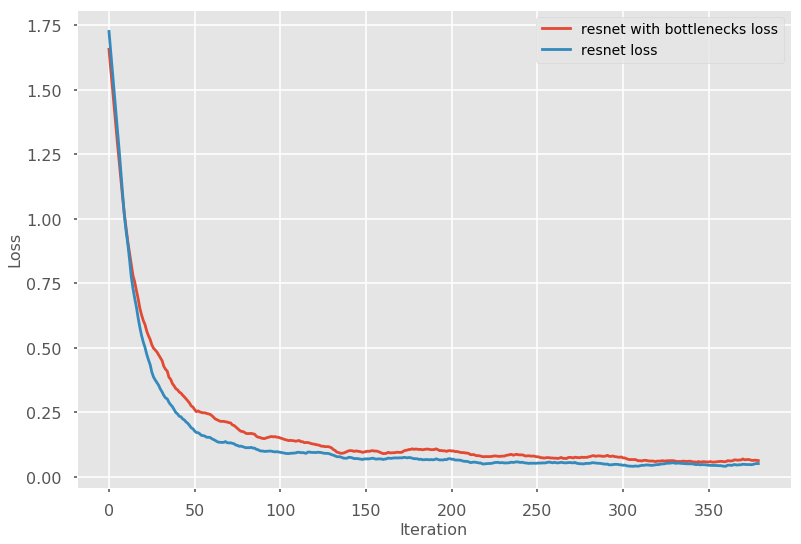

In [42]:
draw(bottle_loss, res_loss)

### Network with bottleneck architectures has almost half the size of parameters, but training not worse than network with simple model. And bottleneck model train faster, than simple model.

### Сonsider the impact of the bottleneck blocks on weights distribution

In [9]:
def get_weights(graph, session):
    
    weights, biases = [], []
    variables = graph.get_collection('trainable_variables')
    names = np.array([layer.name.replace('_',' ').split('/')[0] for layer in variables[:-2:2]][1:])
    weights.append(session.run(variables[::2])[1:])
    biases.append(session.run(variables[1::2]))
    
    return names, np.array(weights[0]), np.array(biases[0])

### Loading graph out of model and get all weights

In [10]:
bottle_sess = train_pipeline.get_model_by_name("bottlenet")[1][-1]
bottle_graph = bottle_sess.graph
bottle_names, bottle_weights, bottle_bias = get_weights(bottle_graph, bottle_sess)

In [11]:
res_sess = train_pipeline.get_model_by_name("resnet")[-1][-1]
res_graph = res_sess.graph
res_names, res_weights, res_bias = get_weights(res_graph, res_sess)

### Let's count the numbers of parameters on each layer.

In [12]:
bottle_params = np.array([np.array(i.shape).prod() for i in bottle_weights] + [0, 0, 0])
res_params = np.array([np.array(i.shape).prod() for i in res_weights])

### Figure, that show distrubution of weights on all layers in simple ResNet model

In [27]:
def separate(layers_names, weights, num_params, bottle):
    def create(layers_names, weights, name, num_params):
        indices = [i for i in range(len(layers_names)) if name in layers_names[i][:8]]
        if name == 'shortcut':
            return np.hstack((weights[indices], [0, 0, 0])), np.hstack((layers_names[indices], [0, 0, 0])), \
                                np.hstack((num_params[indices], [0, 0, 0]))
        
        return weights[indices], layers_names[indices], num_params[indices]

    if bottle == False:
        name = ['first', 'second']
    else:
        name = ['first', 'conv', 'second', 'shortcut']
    data = np.array(create(layers_names, weights, name[0], num_params))
    for i in name[1:]:
        data = np.vstack((data, create(layers_names, weights, i, num_params)))
    names, weights, num_params = data[1::3], data[::3], data[2::3]
    for i in range(5):
        yield names[:, i], weights[:, i], num_params[:, i]

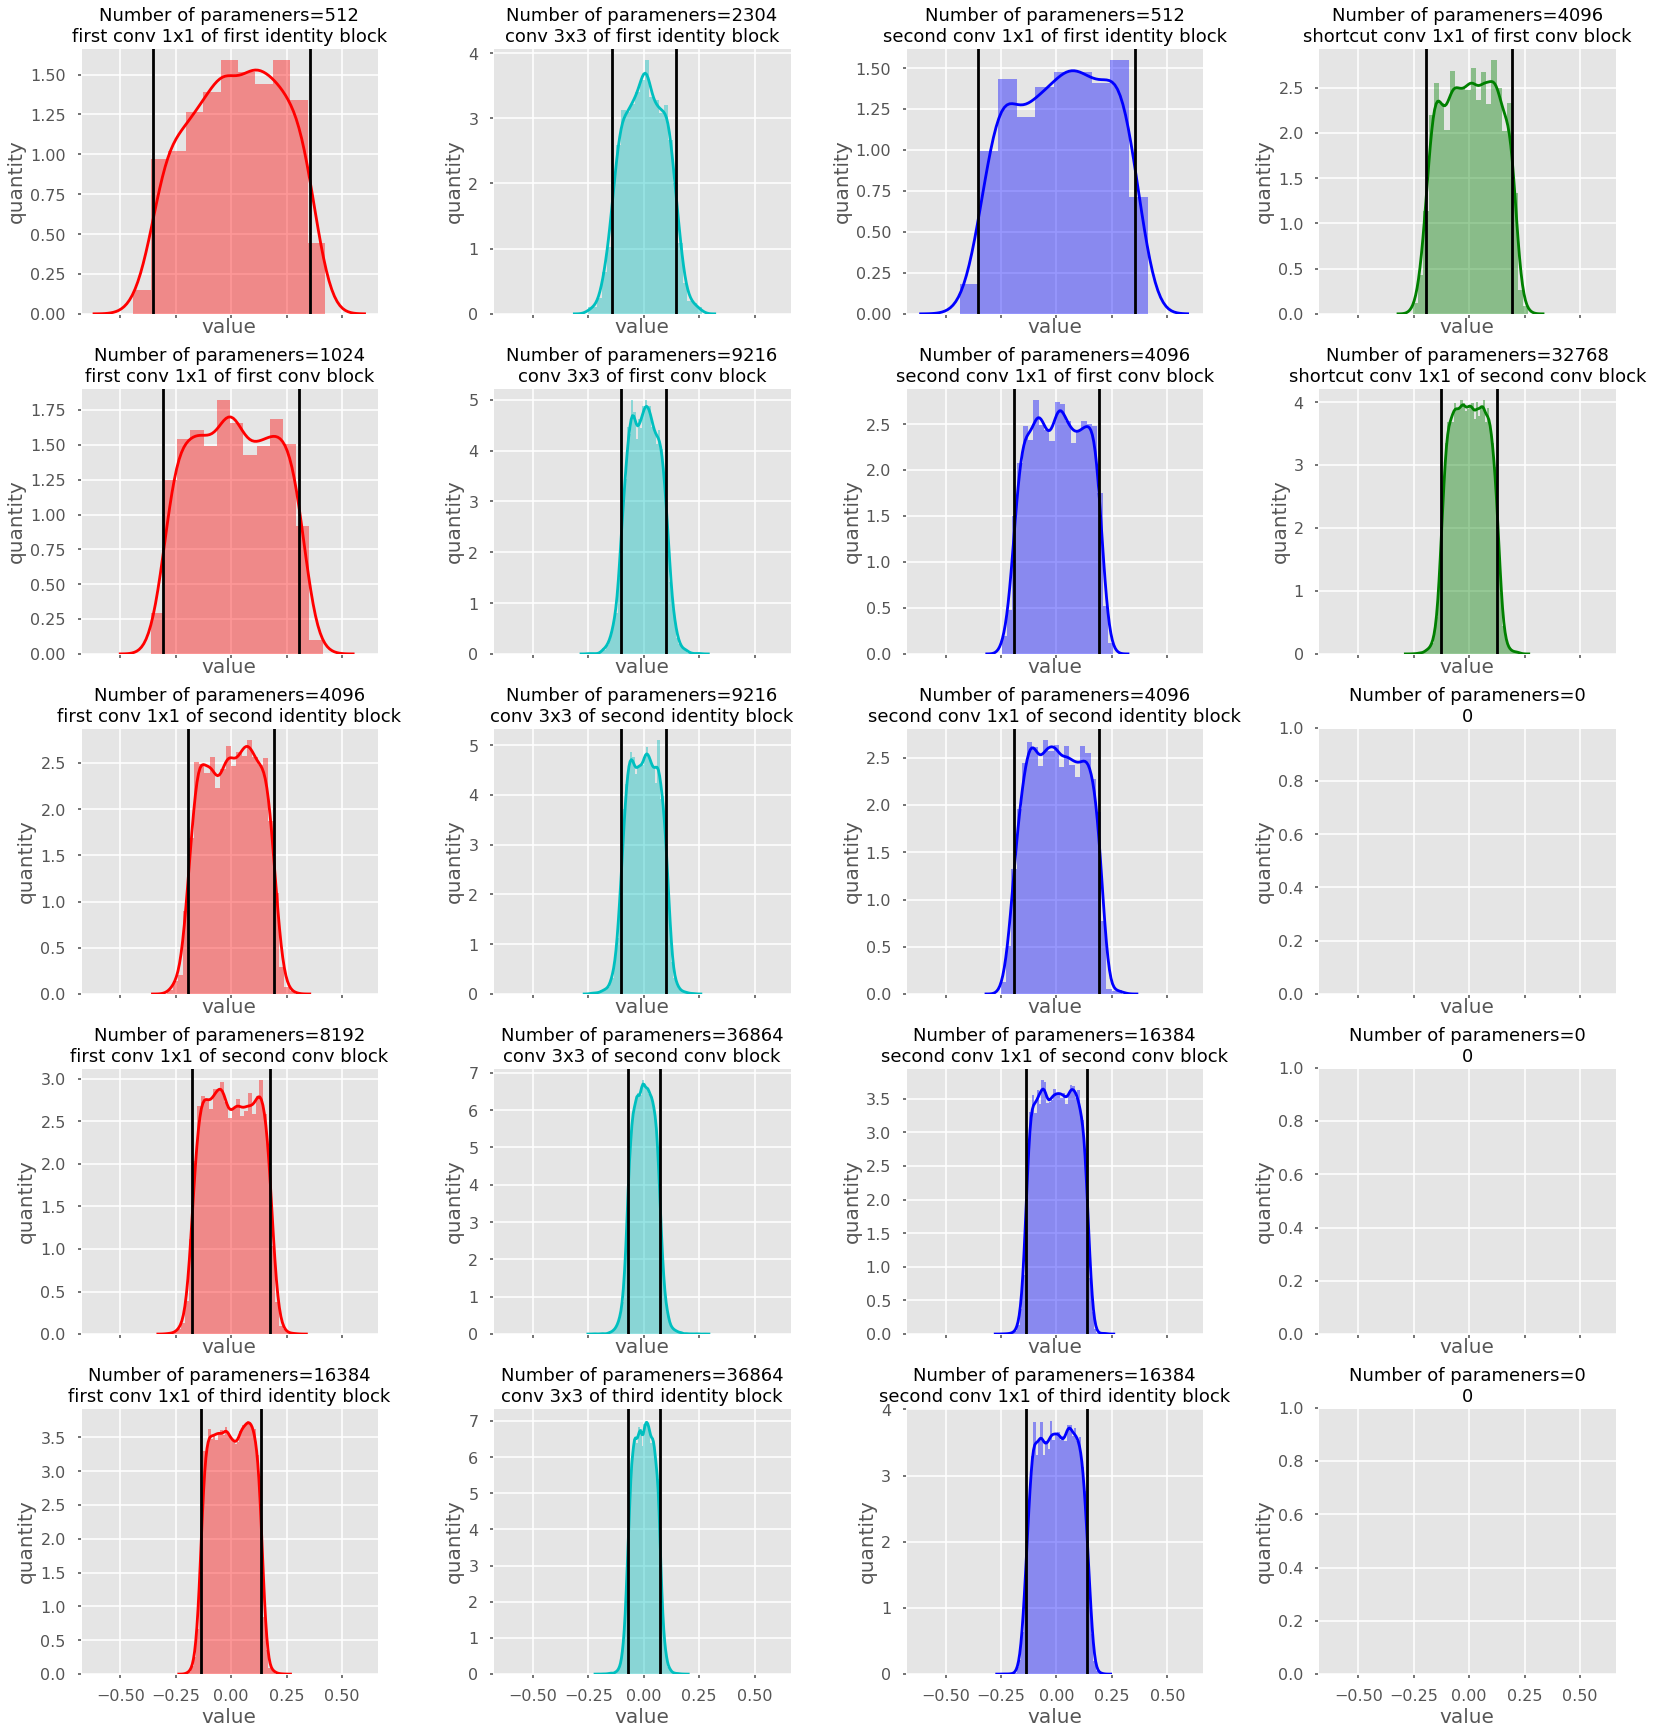

In [33]:
_, ax = plt.subplots(5, 4, sharex='all', figsize=(23,24))
ax = ax.reshape(-1)
num_plot = 0
colors = ['r', 'c', 'b', 'g']

for names, weights, num_params in separate(bottle_names, bottle_weights, bottle_params, True):
    for name, weight, num in zip(names, weights, num_params):
        ax[num_plot].set_title('Number of parameners={}\n{}'.format(num, name), fontsize=18)
        if type(weight) != np.int:
            sns.distplot(weight.reshape(-1), ax=ax[num_plot], color=colors[int(num_plot % 4)])
            if num_plot % 1 == 0:
                dis = (6. / ((weight.shape[2] + weight.shape[3]) * weight.shape[0] * weight.shape[1])) ** 0.5
                ax[num_plot].axvline(x=dis, ymax=10, color='k')
                ax[num_plot].axvline(x=-dis, ymax=10, color='k')
        ax[num_plot].set_xlabel('value', fontsize=20)
        ax[num_plot].set_ylabel('quantity', fontsize=20)
        num_plot+=1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

###  На графиках выше представлены распределения весов в сверточных слоях. Не трудно заметить, что распределение конволюционных слоях с ядром свертки 1х1, как первая, так и вторая, имеют гораздо большую дисперсию, нежели сверточные слои с ядром 3х3 или skipconnections. Поэтому сверточные слои с ядром 1х1 сильнее влияют на выход сети, а сверточный слой с ядром 3х3, из-за того, что в нем гораздо больше параметров не успевает нормально обучиться.

# !Черные линии показывают изначальное распределение весов!

### Figure, that show distrubution of weights on all layers in simple resnet model after training

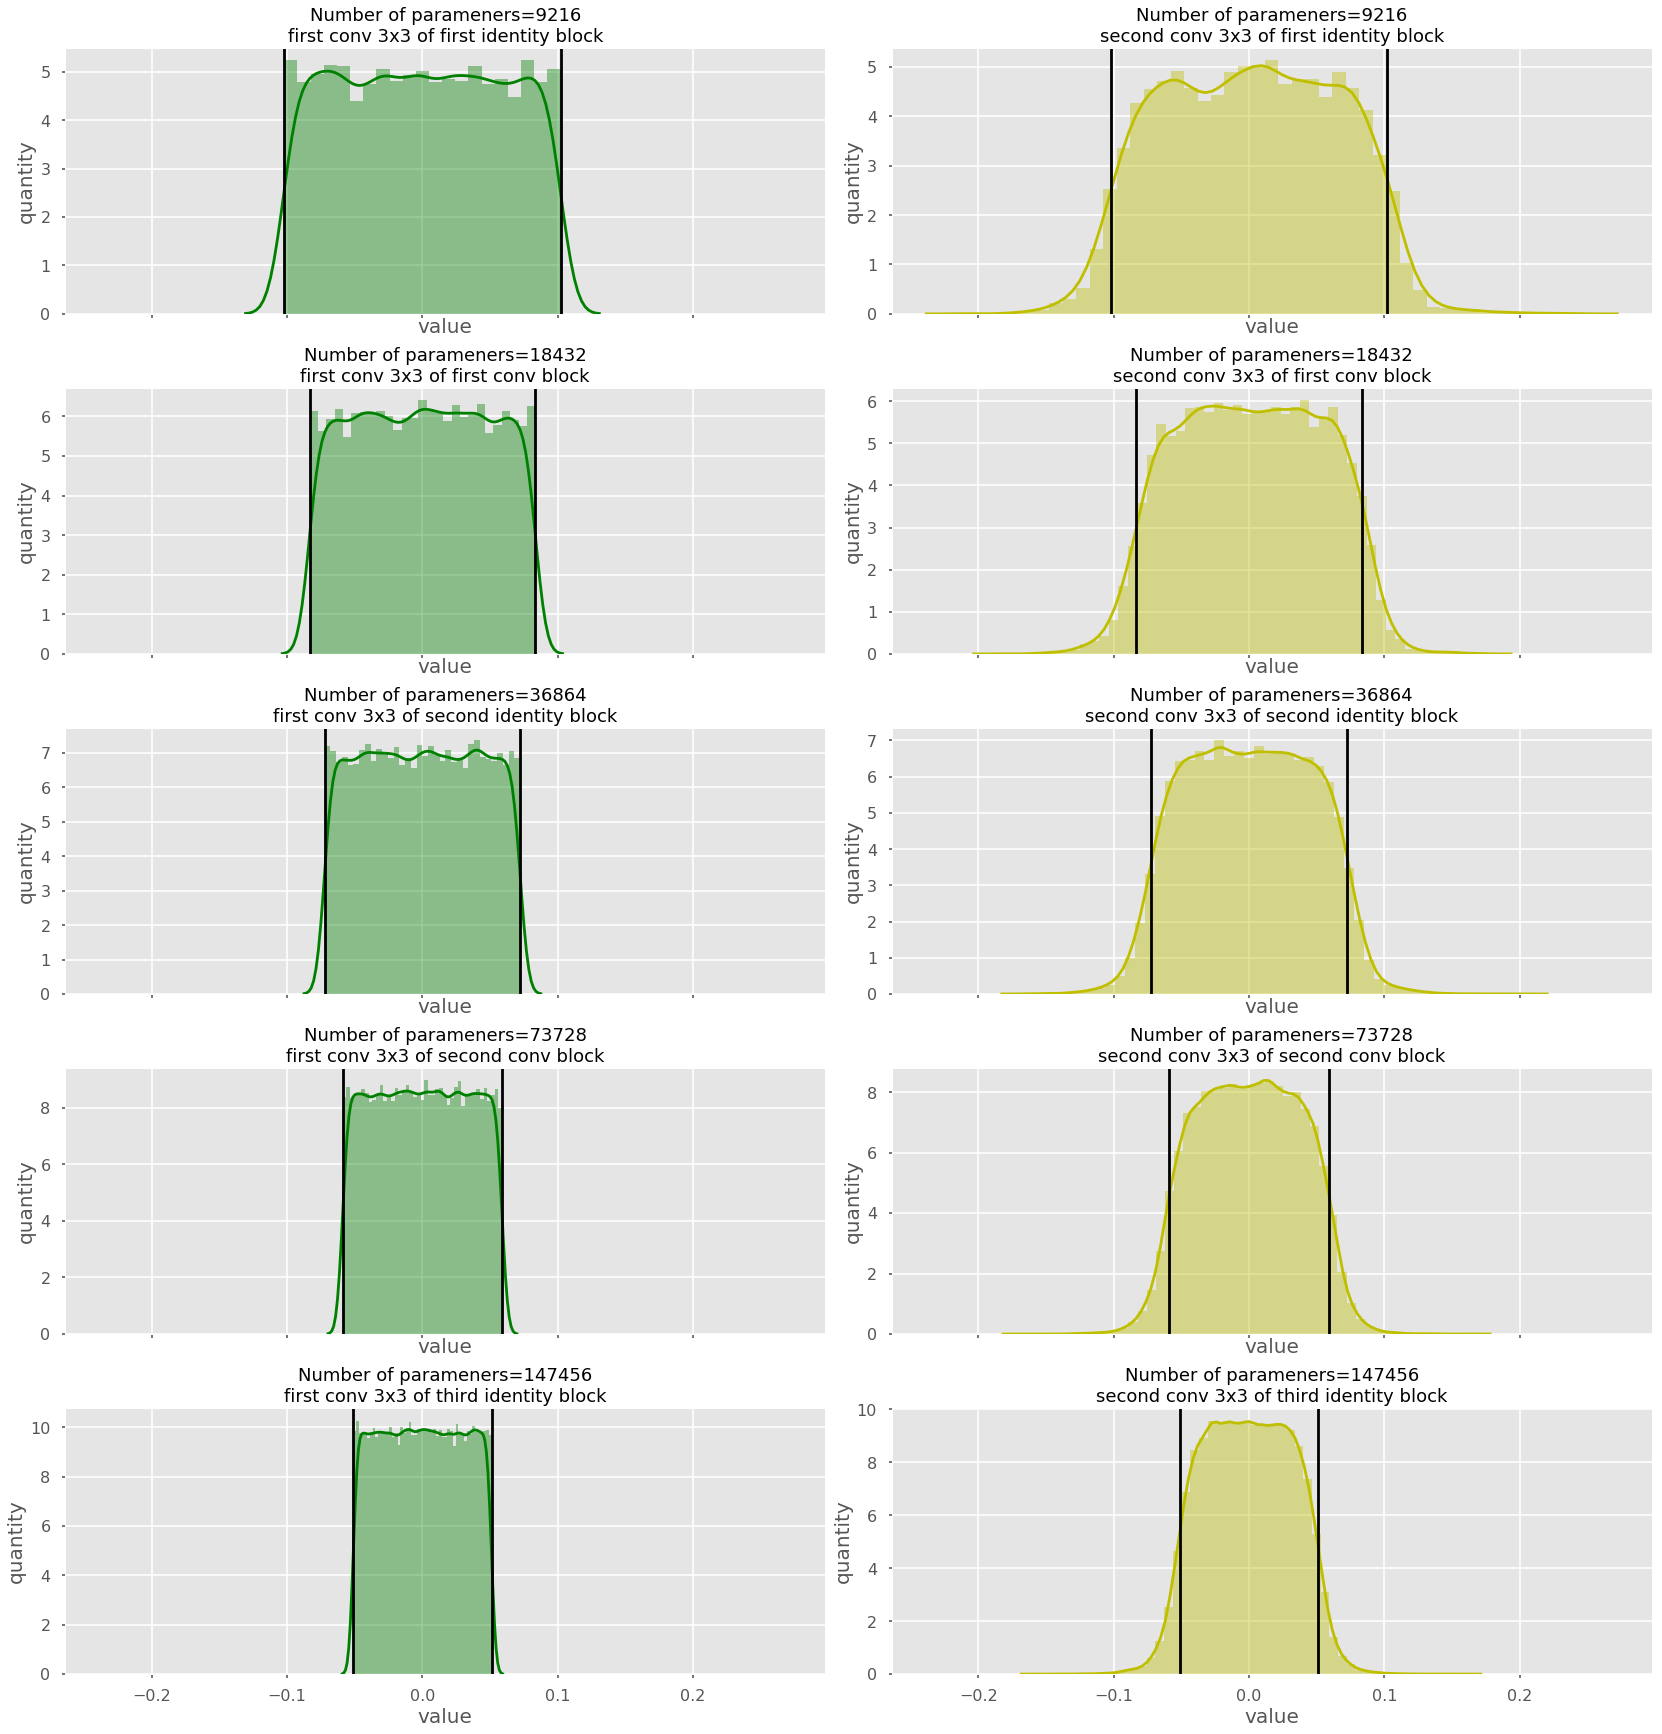

In [34]:
_, ax = plt.subplots(5, 2, sharex='all', figsize=(23,24))
ax = ax.reshape(-1)
num_plot = 0
colors = ['g', 'y']
for names, weights, num_params in separate(res_names, res_weights, res_params, False):
    for name, weight, num in zip(names, weights, num_params):
        ax[num_plot].set_title('Number of parameners={}\n{}'.format(num, name), fontsize=18)
        if type(weight) != np.int:
            sns.distplot(weight.reshape(-1), ax=ax[num_plot], color=colors[int(num_plot % 2)])
            dis = (6. / ((weight.shape[2] + weight.shape[3]) * weight.shape[0] * weight.shape[1])) ** 0.5
            ax[num_plot].axvline(x=dis, ymax=10, c='k')
            ax[num_plot].axvline(x=-dis, ymax=10, c='k')
        ax[num_plot].set_xlabel('value', fontsize=20)
        ax[num_plot].set_ylabel('quantity', fontsize=20)
        num_plot+=1
        
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### На графиках выше показано распределение весов обычной модели. ?Посмотрев на графики видно, что распределения первых сверточных слоев почти не изменилось.? Это происходит потому что градиент на втором слое на порядок больше, чем на первом, благодоря слою skipconnection, а значит веса второго слоя изменяются сильнее, что подтверждается большей дисперсией. Поэтому они вносят больший вклад в конечный функционал, а веса первого слоя за данное количество итераций почти не уходят от начальных значений.

### Теперь давайте сравним распределение весов свертончого слоя (3х3) из bottleneck блока,  и второго сверточного слоя из обычного блока и посмотрим насколько сильно они отличаются.

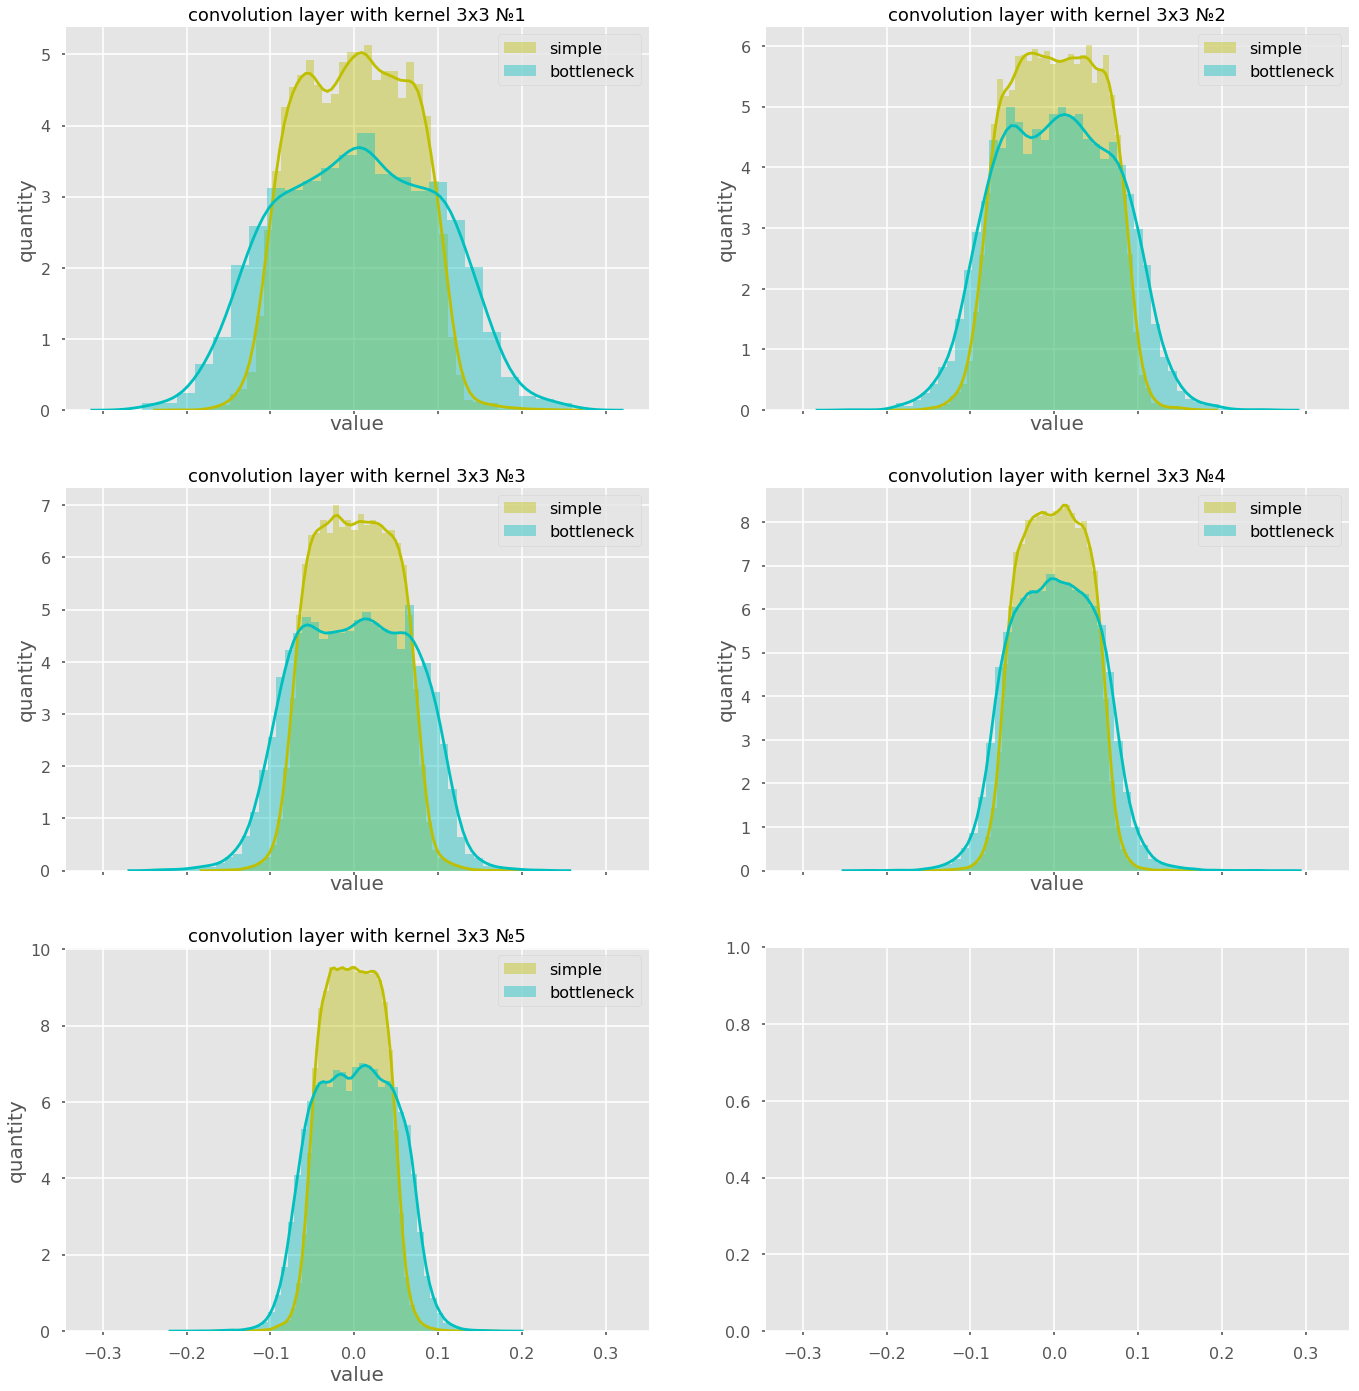

In [31]:
indices = [i for i in range(len(bottle_names)) if 'conv' in bottle_names[i][:8]]
_, ax = plt.subplots(3, 2, sharex='all', figsize=(23,24))
ax = ax.reshape(-1)
num_plot = 0
for i,j in zip(range(1, 10, 2), indices):
    ax[num_plot].set_title('convolution layer with kernel 3x3 №{}'.format(num_plot + 1), fontsize=18)
    sns.distplot(res_weights[i].reshape(-1), ax=ax[num_plot], color='y', label='simple')
    sns.distplot(bottle_weights[j].reshape(-1), ax=ax[num_plot], color='c', label='bottleneck')
    ax[num_plot].legend()
    ax[num_plot].set_xlabel('value', fontsize=20)
    ax[num_plot].set_ylabel('quantity', fontsize=20)
    num_plot += 1
    

### По графикам видно, что дисперсия слоев из bottleneck модели больше, значит bottleneck модель обучаются лучше, чем обычная.
### Из распределения весов в bottleneck модели мы сделали вывод, что свертка 3х3 вносит меньше вклада, чем свертки 1х1, а из распределения весов обычной модели мы сделали вывод, что вторая свертка вносит бОльший вклад, чем первая.
### При сравнении сверток 3х3 в обеих моделях вы видим, что они почти не отличаются друг от друга. А это значит, что разница в качестве моделей будет зависить от перого сверточного слоя 3х3 в обычной модели и сверток 1х1 в bottleneck модели. По причине того, что первом свероточном слое 3х3 параметров гораздо больше, чем в свертках 1х1, он будет обучаться медленнее, это приводит к тому, что обычная модель обучается медленнее и для достижения такого же качества, как в bottleneck модели ей нужно бОльшее количество итераций.

### Подведем итоги:
1. При построении сети из блоков, в которые содержат свертки 1х1 для изменение размерности модель обучается быстрее и достигает большей точности.
2. Для второго слоя после skipcommection-а градиент всегда будет на порядок меньше, чем для первого, а значит скорость его обучения будет в разы меньше.
3. Сверточный слой 1х1 помогает лучше "пропустить" градиент до следущего слоя, благодоря тому, что в нем на в несколько раз меньше параметров и еще сети не выгодно занулять веса, так как зануление какого-то веса в ядре свертки означает полное зануление фильтра.